In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
sns.set_theme()

# Project Context and Deliverables

Due to the significant number of baby boomers exploring nursing home options, your company has been tasked with determining whether it is advisable to suggest your client invest in nursing homes. As a member of the data analysis team, you are required to perform an analysis to address this question. Your team has acquired a comprehensive dataset of U.S. nursing homes for the years 2015-2021. Your analysis of this data must address the following topics

**The project has the following deliverable**s:

1. Evaluate the overall financial performance of nursing homes in the United States during this period. (Descriptive Analytics)
2. Identify the influential factors affecting the financial performance of nursing homes.
3. Determine the most significant factors impacting the performance of nursing homes.
4. Describe the trends in performance and these influential factors.
5. Analyze the impact of COVID-19.

---

# Data Loading

Let's consolidate the `CostReport` files into one df. One remark about this task:

- Because years 2015 - 2019 and years 2020 - 2021 do not have the same set of columns (omitting of underscores and slightly different column header names), we will handle each in separate loops, then concat the frames together. This was handled in Excel.
- We will use a `for` loop to make this easier

In [197]:
# Loop through each year, read the CSV file, add a 'Year' column, and append to the list
# Paste in the respective file path in each return statement
def get_file_path():
    if os.name == 'nt':  # Windows
        return r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data'
    else:  # macOS or other Unix-like OS
        return '/Users/josh/Library/CloudStorage/OneDrive-Personal/Desktop Files/Textbooks and Syllabi/CSUN Semester 6/BANA 620/Project/Data'

base_path = get_file_path()
years = ['2015', '2016', '2017', '2018', '2019']
dataframes = []

for year in years:
    file_path = os.path.join(base_path, f'{year}_CostReport.csv')
    df = pd.read_csv(file_path)
    df['Year'] = year  # Add a 'Year' column
    dataframes.append(df)

# Concatenate all DataFrames into one
costReportdf = pd.concat(dataframes, ignore_index=True)

C:\Users\joshu\AppData\Local\Temp\ipykernel_39596\2689924121.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [198]:
# 2020 and 2021
base_path = get_file_path()
years = ['2020', '2021']
dataframes = []

for year in years:
    file_path = os.path.join(base_path, f'{year}_CostReport.csv')
    df = pd.read_csv(file_path)
    df['Year'] = year  # Add a 'Year' column
    dataframes.append(df)

# Concatenate all DataFrames into one
costReportdf20to21 = pd.concat(dataframes, ignore_index=True)

costReportdf20to21.head()

,rpt_rec_num,Provider CCN,Facility Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural versus Urban,...,Net Patient Revenue,Less Total Operating Expense,Net Income from service to patients,Total Other Income,Total Income,Net Income,Inpatient PPS Amount,Nursing and Allied Health Education Activities,Allowable Bad Debts,Year
0,1254744,75031,GLEN HILL CENTER,1 GLEN HILL ROAD,DANBURY,CT,06811,FAIRFIELD,14860.0,U,...,1083396.0,1023062.0,60334.0,50.0,60384.0,60384.0,476754.0,NaN,4814.0,2020
1,1255877,495268,MARY WASHINGTON HEALTH CENTER,2400 MCKINNEY BLVD,COLONIAL BEACH,VA,22443,WESTMORELAND,99949.0,R,...,814204.0,1076191.0,-261987.0,806.0,-261181.0,-261181.0,101663.0,NaN,NaN,2020
2,1256270,295107,ADVANCED HEALTH CARE OF PARADISE,3455 PECOS-MCLEOD INTERCONNECT,LAS VEGAS,NV,89121,CLARK,29820.0,U,...,1543399.0,1735321.0,-191922.0,120.0,-191802.0,-191802.0,1263318.0,NaN,NaN,2020
3,1259169,146097,EL PASO HEALTH CARE CENTER,850 EAST SECOND STREET,EL PASO,IL,61738,WOODFORD,37900.0,U,...,877453.0,914701.0,-37248.0,349.0,-36899.0,-36899.0,67241.0,NaN,3876.0,2020
4,1259189,215136,BIRCH MANOR CTR FOR REHAB & HEALTHCA,7309 SECOND AVE,SYKESVILLE,MD,21784,CARROLL,12580.0,U,...,2038599.0,1880948.0,157651.0,20.0,157671.0,157671.0,342853.0,NaN,NaN,2020


In [199]:
# rename columns to match 2015 - 2019 frame
costReportdf20to21.columns = ['rpt_rec_num',
'Provider_CCN',
'Facility_Name',
'Street_Address',
'City',
'State_Code',
'Zip_Code',
'County',
'Medicare_CBSA_Number',
'Rural_versus_Urban',
'Fiscal_Year_Begin_Date',
'Fiscal_Year_End_Date',
'Type_of_Control',
'Total_Days_Title_V',
'Total_Days_Title_XVIII',
'Total_Days_Title_XIX',
'Total_Days_Other',
'Total_Days_Total',
'Number_of_Beds',
'Total_Bed_Days_Available',
'Total_Discharges_Title_V',
'Total_Discharges_Title_XVIII',
'Total_Discharges_Title_XIX',
'Total_Discharges_Title_Other',
'Total_Discharges_Total',
'SNF_Average_Length_of_Stay_Title_V',
'SNF_Average_Length_stay_XVIII',
'SNF_Average_Length_stay_XIX',
'SNF_Average_Length_of_stay_Tot',
'SNF_Admissions_Title_V',
'SNF_Admissions_Title_XVIII',
'SNF_Admissions_Title_XIX',
'SNF_Admissions_Other',
'SNF_Admissions_Total',
'SNF_Days_Title_V',
'SNF_Days_Title_XVIII',
'SNF_Days_Title_XIX',
'SNF_Days_Other',
'SNF_Days_Total',
'SNF_Number_of_Beds',
'SNF_Bed_Days_Available',
'SNF_Discharges_Title_V',
'SNF_Discharges_Title_XVIII',
'SNF_Discharges_Title_XIX',
'SNF_Discharges_Title_Other',
'SNF_Discharges_Total',
'NF_Number_of_Beds',
'NF_Bed_Days_Available',
'NF_Days_Title_V',
'NF_Days_Title_XIX',
'NF_Days_Other',
'NF_Days_Total',
'NF_Discharges_Title_V',
'NF_Discharges_Title_XIX',
'NF_Discharges_Title_Other',
'NF_Discharges_Total',
'NF_Average_Length_of_Stay_Title_V',
'NF_Average_Length_of_Stay_Title_XIX',
'NF_Average_Length_of_Stay_Total',
'NF_Admissions_Title_V',
'NF_Admissions_Title_XIX',
'NF_Admissions_Other',
'NF_Admissions_Total',
'Total_RUG_Days',
'Total_Salaries_From_Worksheet_A',
'Overhead_Non_Salary_Costs',
'Total_Charges',
'Total_Costs',
'Wage_related_Costs_core',
'Total_Salaries_adjusted',
'Contract_Labor',
'Cash_on_hand_and_in_banks',
'Temporary_Investments',
'Notes_Receivable',
'Accounts_Receivable',
'Less:_Allowances_for_uncollectible_notes_and_accounts_receivable',
'Inventory',
'Prepaid_expenses',
'Other_current_assets',
'Total_Current_Assets',
'Land',
'Land_improvements',
'Buildings',
'Leasehold_improvements',
'Fixed_equipment',
'Major_movable_equipment',
'Minor_equipment_depreciable',
'Total_fixed_Assets',
'Investments',
'Other_Assets',
'Total_other_Assets',
'Total_Assets',
'Accounts_payable',
'Salaries_wages_and_fees_payable',
'Payroll_taxes_payable',
'Notes_and_Loans_Payable_(short_term)',
'Deferred_income',
'Other_current_liabilities',
'Total_current_liabilities',
'Mortgage_payable',
'Notes_Payable',
'Unsecured_Loans',
'Other_long_term_liabilities',
'Total_long_term_liabilities',
'Total_liabilities',
'General_fund_balance',
'Total_fund_balances',
'Total_Liab_and_fund_balances',
'Total_General_Inpatient_Revenue',
'Inpatient_Revenue',
'Outpatient_Revenue',
'Gross_Revenue',
'Less_discounts_on_patients',
'Net_Patient_Revenue',
'Less_Total_Operating_Expense',
'Net_Income_from_patients',
'Total_Other_Income',
'Total_Income',
'Net_Income',
'Inpatient_PPS_Amount',
'Nursing_and_Allied_Health_Education_Activities',
'Allowable_Bad_Debts',
'Year']

In [200]:
fullCostReportdf = pd.concat([costReportdf, costReportdf20to21], ignore_index=True)

In [201]:
# dropping columns found only in the 2020 - 2021 set
fullCostReportdf.drop(['Total_Days_Title_V',
 'Total_Discharges_Title_V',
 'SNF_Average_Length_of_Stay_Title_V',
 'SNF_Admissions_Title_V',
 'SNF_Days_Title_V',
 'SNF_Number_of_Beds',
 'SNF_Bed_Days_Available',
 'SNF_Discharges_Title_V',
 'NF_Number_of_Beds',
 'NF_Bed_Days_Available',
 'NF_Days_Title_V',
 'NF_Days_Title_XIX',
 'NF_Days_Other',
 'NF_Days_Total',
 'NF_Discharges_Title_V',
 'NF_Discharges_Title_XIX',
 'NF_Discharges_Title_Other',
 'NF_Discharges_Total',
 'NF_Average_Length_of_Stay_Title_V',
 'NF_Average_Length_of_Stay_Title_XIX',
 'NF_Average_Length_of_Stay_Total',
 'NF_Admissions_Title_V',
 'NF_Admissions_Title_XIX',
 'NF_Admissions_Other',
 'NF_Admissions_Total',
 'Total_Charges',
 'Contract_Labor',
 'Temporary_Investments',
 'Notes_Receivable',
 'Less:_Allowances_for_uncollectible_notes_and_accounts_receivable',
 'Inventory',
 'Prepaid_expenses',
 'Other_current_assets',
 'Total_Current_Assets',
 'Land',
 'Land_improvements',
 'Leasehold_improvements',
 'Minor_equipment_depreciable',
 'Investments',
 'Payroll_taxes_payable',
 'Notes_and_Loans_Payable_(short_term)',
 'Deferred_income',
 'Mortgage_payable',
 'Notes_Payable',
 'Unsecured_Loans',
 'Other_long_term_liabilities',
 'Total_long_term_liabilities',
 'Outpatient_Revenue',
 'Total_Other_Income',
 'Nursing_and_Allied_Health_Education_Activities',
 'Allowable_Bad_Debts'], axis=1, inplace=True)

In [202]:
# convert column headers to all lower for consistentcy
fullCostReportdf.columns = fullCostReportdf.columns.str.lower()

In [203]:
# # Save file for reference and for use in Tableau / PowerBI
# output_path = r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\Consolidated_CostReport.csv'
# fullCostReportdf.to_csv(output_path, index=False)

## Data Cleaning and Preprocessing

### Identifying and handling outliers.

In [204]:
# dealing with a subset of outliers by z-score threshold
def removeOutliers(input_df, column_name, zScoreThreshold):
    mean = input_df[column_name].mean()
    std = input_df[column_name].std()
    z_scores = (input_df[column_name] - mean) / std

    return input_df[(z_scores > -zScoreThreshold) & (z_scores < zScoreThreshold)]

numerical_columns = ['net_income', 'accounts_payable']
for each in numerical_columns:
   df = removeOutliers(fullCostReportdf, each, 3)

There are also some suspect records based on data entry. Looking at bed counts:

In [205]:
bedList = df['number_of_beds'].sort_values(ascending=False)
bedList.to_frame()
bedList.head(15)

43153    12043800.0
83260       71430.0
38005       54385.0
69707       28470.0
41132       28470.0
54900       28470.0
54460       27375.0
38666       23964.0
93395       22287.0
73501       21900.0
46990       21900.0
79098        5892.0
16058        5254.0
28919        5178.0
89460        3103.0
Name: number_of_beds, dtype: float64

We will delete the records which report 21k beds or more.

In [206]:
bedThreshold = 21000

# Filter the DataFrame to keep only the rows where 'Number_of_Beds' is less than or equal to the threshold
df = df[df['number_of_beds'] <= bedThreshold]

### Dropping null records

In [207]:
# viewing the nulls before cleaning
def getNulls():
    nullList = df.isna().sum()

    nullFrame = pd.DataFrame(nullList, columns=['nullCount'])
    nullFrame.reset_index(inplace=True)

    nullFrame.columns = ['feature', 'nullCount']
    nullFrame = nullFrame[nullFrame['nullCount'] != 0]
    
    return nullFrame
    
getNulls()

,feature,nullCount
3,street_address,9
8,medicare_cbsa_number,47
9,rural_versus_urban,112
13,accounts_receivable,1903
15,buildings,59348
16,cash_on_hand_and_in_banks,1486
17,general_fund_balance,239
18,gross_revenue,6
19,inpatient_pps_amount,99
20,inpatient_revenue,6


In [208]:
dropnaList = ['gross_revenue', 'net_income', 'total_assets', 'total_costs', 'total_discharges_total', 'total_income', 'total_liab_and_fund_balances', 'rural_versus_urban', 'accounts_receivable']
df.dropna(subset=dropnaList, inplace=True)

### Culling columns
We will drop the following:

Dropping due to large percentage (more than 10%) of `null` values:
- `buildings`
- `major_moveable_equipment`
- `fixed_equipment`
- `'snf_admissions_title_xix'`
- `'snf_average_length_stay_xix`'
- `'snf_days_title_xix`'
- `'snf_discharges_title_xix`'
- `'snf_bed_days_available`'
- `'snf_number_of_beds`'
- `'total_days_title_xix`'
- `'total_discharges_title_xix`'
- `'total_rug_days`'

Dropping due to irrelevance to target feature:
- Identifiers

Dropping due to redundancy:
- Captured by `year`:
    - `fiscal_year_begin_date`
    - `fiscal_year_end_date`
- Captured within `total_assets` (definition of `total_assets` in data dictionary):
    - `other_assets`
    - `'total_current_assets'`
    - `'total_fixed_assets'`
    - `'total_other_assets'`

- `'total_salaries_from_worksheet_a',`: duplicate with `'total_salaries_adjusted'`

In [209]:
dropNull = ['buildings', 'major_movable_equipment', 'fixed_equipment', 'snf_admissions_title_xix', 'snf_average_length_stay_xix', 'snf_days_title_xix', 'snf_discharges_title_xix', 'snf_bed_days_available', 'snf_number_of_beds', 'total_days_title_xix', 'total_discharges_title_xix', 'total_rug_days']
dropRedundancy = ['fiscal_year_begin_date', 'fiscal_year_end_date', 'other_assets', 'total_current_assets', 'total_fixed_assets', 'total_other_assets', 'total_salaries_from_worksheet_a', 'other_current_liabilities', 'total_income']
dropInsignificant = []
dropList = dropNull + dropRedundancy + dropInsignificant

In [210]:
df.columns.to_list()

['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'state_code',
 'zip_code',
 'county',
 'medicare_cbsa_number',
 'rural_versus_urban',
 'fiscal_year_begin_date',
 'fiscal_year_end_date',
 'type_of_control',
 'accounts_receivable',
 'accounts_payable',
 'buildings',
 'cash_on_hand_and_in_banks',
 'general_fund_balance',
 'gross_revenue',
 'inpatient_pps_amount',
 'inpatient_revenue',
 'less_total_operating_expense',
 'less_discounts_on_patients',
 'major_movable_equipment',
 'net_income',
 'net_income_from_patients',
 'net_patient_revenue',
 'number_of_beds',
 'other_assets',
 'other_current_liabilities',
 'overhead_non_salary_costs',
 'snf_admissions_other',
 'snf_admissions_title_xix',
 'snf_admissions_title_xviii',
 'snf_admissions_total',
 'snf_average_length_of_stay_tot',
 'snf_average_length_stay_xix',
 'snf_average_length_stay_xviii',
 'snf_days_other',
 'snf_days_title_xix',
 'snf_days_title_xviii',
 'snf_days_total',
 'snf_discharges_title_other',

In [211]:
df.drop(columns=dropList, inplace=True, axis=1)

In [212]:
# viewing nulls after column culling
getNulls()

,feature,nullCount
3,street_address,9
8,medicare_cbsa_number,45
13,cash_on_hand_and_in_banks,1445
14,general_fund_balance,64
16,inpatient_pps_amount,76
19,less_discounts_on_patients,5836
25,snf_admissions_other,1656
26,snf_admissions_title_xviii,857
27,snf_admissions_total,596
28,snf_average_length_of_stay_tot,10


### Handling Remaining Nulls: Mean Imputation

Because the remaining number of remaining null values is quite low relative to the data set, let's handle these with mean imputation. 

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98610 entries, 0 to 106267
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   rpt_rec_num                      98610 non-null  int64  
 1   provider_ccn                     98610 non-null  int64  
 2   facility_name                    98610 non-null  object 
 3   street_address                   98601 non-null  object 
 4   city                             98610 non-null  object 
 5   state_code                       98610 non-null  object 
 6   zip_code                         98610 non-null  object 
 7   county                           98610 non-null  object 
 8   medicare_cbsa_number             98565 non-null  object 
 9   rural_versus_urban               98610 non-null  object 
 10  type_of_control                  98610 non-null  float64
 11  accounts_receivable              98610 non-null  float64
 12  accounts_payable 

### Null String: imputation of `missing`

In [214]:
df['street_address'].fillna(value="missing", inplace=True)
df['medicare_cbsa_number'].fillna(value="missing", inplace=True)

nullFrame = getNulls()

meanImputationList = nullFrame['feature'].tolist()
meanImputationList

for each in meanImputationList:
    df[each].fillna(round(df[each].mean()), inplace=True)

In [215]:
df.columns.to_list()

['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'state_code',
 'zip_code',
 'county',
 'medicare_cbsa_number',
 'rural_versus_urban',
 'type_of_control',
 'accounts_receivable',
 'accounts_payable',
 'cash_on_hand_and_in_banks',
 'general_fund_balance',
 'gross_revenue',
 'inpatient_pps_amount',
 'inpatient_revenue',
 'less_total_operating_expense',
 'less_discounts_on_patients',
 'net_income',
 'net_income_from_patients',
 'net_patient_revenue',
 'number_of_beds',
 'overhead_non_salary_costs',
 'snf_admissions_other',
 'snf_admissions_title_xviii',
 'snf_admissions_total',
 'snf_average_length_of_stay_tot',
 'snf_average_length_stay_xviii',
 'snf_days_other',
 'snf_days_title_xviii',
 'snf_days_total',
 'snf_discharges_title_other',
 'snf_discharges_title_xviii',
 'snf_discharges_total',
 'salaries_wages_and_fees_payable',
 'total_assets',
 'total_bed_days_available',
 'total_costs',
 'total_days_other',
 'total_days_title_xviii',
 'total_days_total',
 

Now that the cleaning is complete, let's perform some eploratory data analysis.

# EDA

## Feature Engineering
Several features which can be useful metrics for determing financial health need to be calculated:

1. **Revenue Growth:**
    - You can calculate the year-over-year percentage change in **`gross_revenue`**.
2. **Profit Margins:**
    - Gross Profit Margin: (**`gross_revenue`** - **`total_costs`**) / **`gross_revenue`**.
    - Net Profit Margin: **`net_income`** / **`gross_revenue`**.
3. **Operational Efficiency:**
    - Total Operating Expense Ratio: **`less_total_operating_expense`** / **`gross_revenue`**.
4. **Liquidity Ratios:**
    - Current Ratio: **`total_current_assets`** / **`total_current_liabilities`**.
5. **Solvency Ratios:**
    - Debt-to-Equity Ratio: **`total_liabilities`** / **`total_fund_balances`**.
6. **Return on Investment (ROI):**
    - ROI: **`net_income`** / **`total_assets`**.
7. **Capacity Utilization:**
    - Bed Occupancy Rate: **`total_days_total`** / (**`number_of_beds`** * 365).
8. **Cost Management:**
    - Cost per Bed: **`total_costs`** / **`number_of_beds`**.
    - Salary Costs per Bed: **`total_salaries_adjusted`** / **`number_of_beds`**.

In [216]:
## Adding financial metrics calculations
df['gross_profit_margin'] = (df['gross_revenue'] - df['total_costs']) / df['gross_revenue']
df['net_profit_margin'] = df['net_income'] / df['gross_revenue']
df['operating_expense_ratio'] = df['total_costs'] / df['gross_revenue']
df['assets_to_liability_ratio'] = df['total_assets'] / df['total_liabilities']
df['debt_to_equity_ratio'] = df['total_liabilities'] / df['total_fund_balances']
df['roi'] = df['net_income'] / df['total_assets']
df['bed_occupancy_rate'] = df['total_days_total'] / (df['number_of_beds'] * 365)
df['cost_per_bed'] = df['total_costs'] / df['number_of_beds']
df['salary_costs_per_bed'] = df['total_salaries_adjusted'] / df['number_of_beds']
df['bed_utilization_rate'] = df['total_days_total'] / df['total_bed_days_available']

Creating these features let's us identify some more outlier records that would negatively impact model performance. We address the following:

In [217]:
costPerBedThreshold = 200000

# Filter the DataFrame to keep only the rows where 'Number_of_Beds' is less than or equal to the threshold
df = df[df['cost_per_bed'] <= costPerBedThreshold]

In [218]:
df = df[df['operating_expense_ratio'] <= 2]
df = df[df['operating_expense_ratio'] >= -2]

In [219]:
# windows path
# output_path_feat_engineer = r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\CostReportFeatEngineer.csv'

#macos path
#output_path_feat_engineer = '/Users/josh/Library/CloudStorage/OneDrive-Personal/Desktop Files/Textbooks and Syllabi/CSUN Semester 6/BANA 620/Project/Data/CostReportFeatEngineer.csv'

# df.to_csv(output_path_feat_engineer, index=False)

## Financial Performance Metrics Analysis

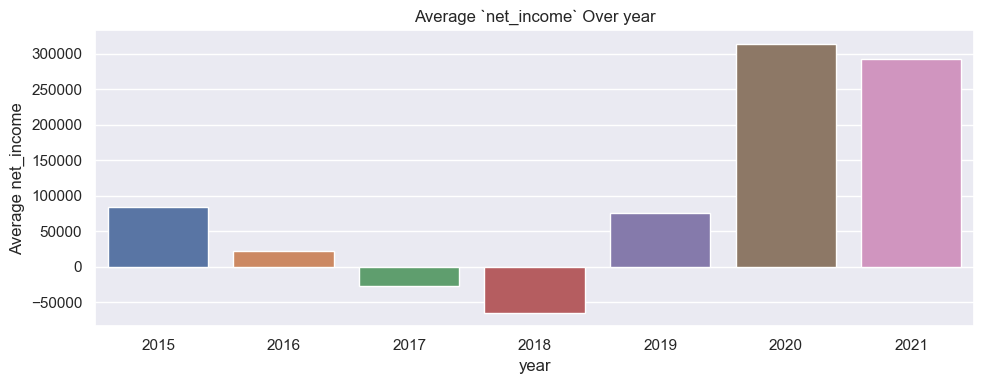

In [220]:
def plot_numerical_features_over_time(df, numerical_columns, group_by_column):
    """
    Plots line graphs for each numerical feature in the DataFrame grouped by the specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - numerical_columns: List of column names for numerical features to plot.
    - group_by_column: Column name to group the data by (e.g., 'Year').
    """
    # Set the size of the plots
    plt.figure(figsize=(10, len(numerical_columns) * 4))
    
    # Iterate over each numerical feature and create a subplot
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 1, i)
        sns.barplot(x=group_by_column, y=column, data=df.groupby(group_by_column).mean(numeric_only=True).reset_index())
        plt.title(f'Average `{column}` Over {group_by_column}')
        plt.xlabel(group_by_column)
        plt.ylabel(f'Average {column}')
        plt.tight_layout()
    
    # Show the plots
    plt.show()
    
numerical_features = ['net_income']
plot_numerical_features_over_time(df, numerical_features, 'year')

C:\Users\joshu\AppData\Local\Temp\ipykernel_39596\391814143.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


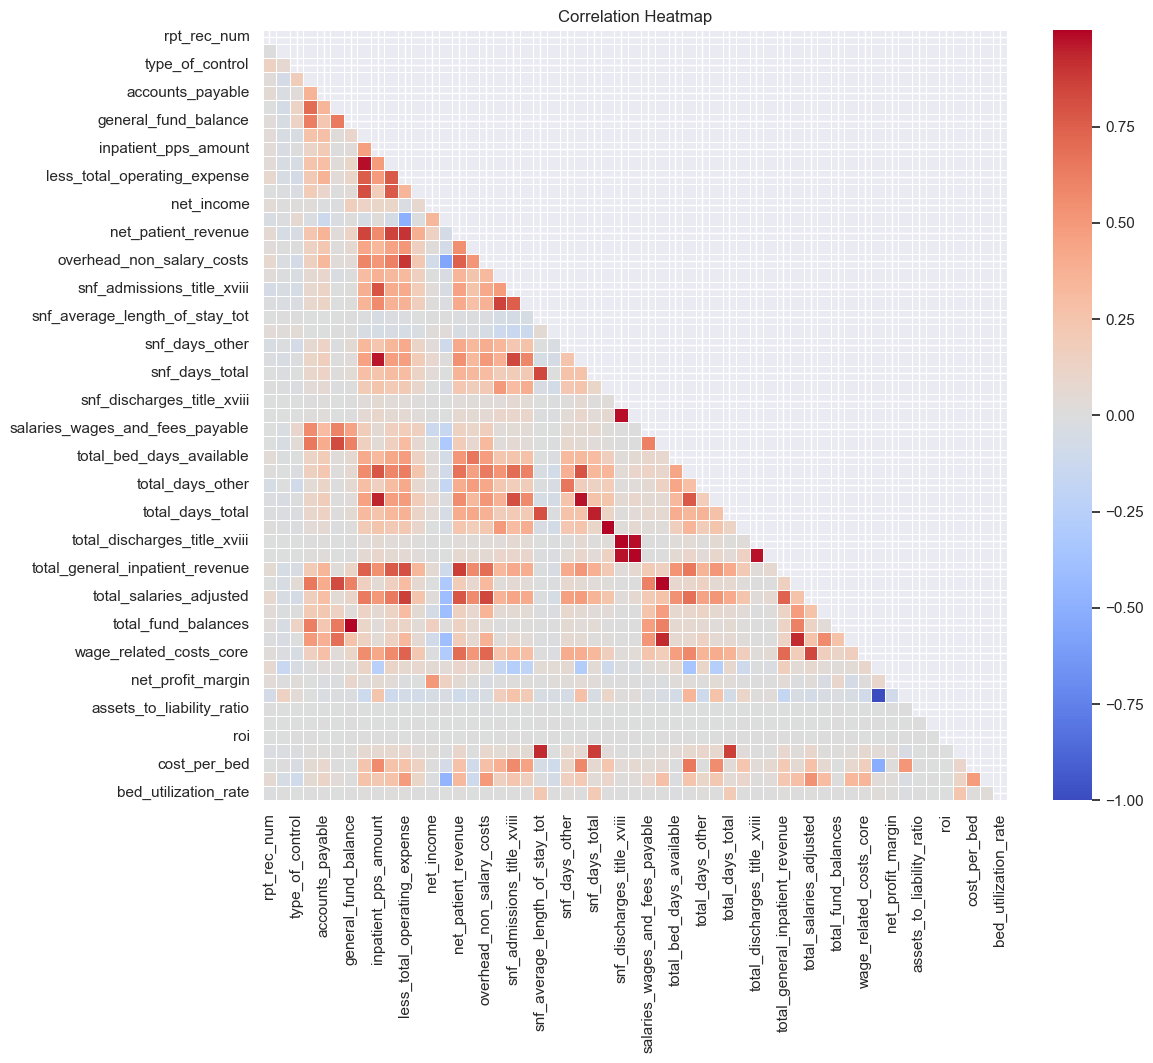

In [221]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", 
            mask=mask, cbar=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='number_of_beds', ylabel='net_income'>

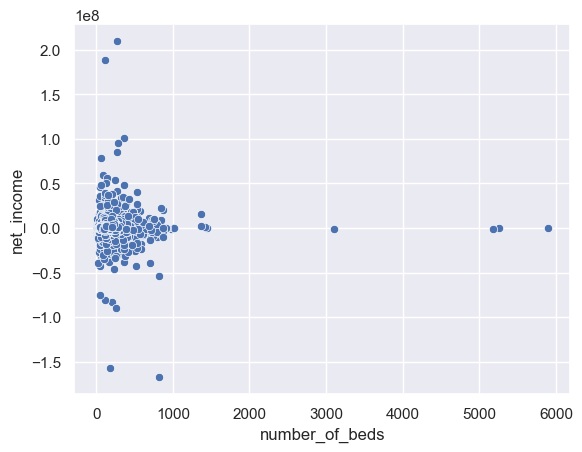

In [222]:
sns.scatterplot(data=df, x='number_of_beds', y='net_income')

# Model Building

Let's do some preliminary tasks before we input input our models.
- Drop some more columns
- StandardScaler()
- One-hot encoding

In [223]:
# keep the df with identifers
dfWithIdentifiers = df.copy()

# this drops data such as identifiers, redundant addresses
preModelDropList = ['rpt_rec_num',
 'provider_ccn',
 'facility_name',
 'street_address',
 'city',
 'zip_code',
 'county', 
 'medicare_cbsa_number',
 'year']

In [224]:
df.drop(columns = preModelDropList, inplace = True, axis = 1)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98600 entries, 0 to 106267
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   state_code                       98600 non-null  object 
 1   rural_versus_urban               98600 non-null  object 
 2   type_of_control                  98600 non-null  float64
 3   accounts_receivable              98600 non-null  float64
 4   accounts_payable                 98600 non-null  float64
 5   cash_on_hand_and_in_banks        98600 non-null  float64
 6   general_fund_balance             98600 non-null  float64
 7   gross_revenue                    98600 non-null  float64
 8   inpatient_pps_amount             98600 non-null  float64
 9   inpatient_revenue                98600 non-null  float64
 10  less_total_operating_expense     98600 non-null  float64
 11  less_discounts_on_patients       98600 non-null  float64
 12  net_income       

In [226]:
numericalFeatures = df.select_dtypes(exclude=['object']).columns.to_list()
numericalFeatures.remove('net_income')
categoricalFeatures = df.select_dtypes(include=['object']).columns.to_list()

In [227]:
for each in categoricalFeatures:
    df = pd.concat([df, pd.get_dummies(df[each], prefix=each)], axis = 1)
    
df.drop(columns=categoricalFeatures, inplace=True, axis=1)

## Model Building and Fit:
- Linear Regression
- Ridge
- Lasso
- ElasticNet
- KNN

In [228]:
def evaluate_regression_models(df, target_column, scaler, test_size=0.1, random_state=123):
    """
    Evaluate various regression models on a given DataFrame with specified scaler.

    Parameters:
    - df : DataFrame containing the data.
    - target_column : string, the name of the column to predict.
    - scaler : Scaler object from sklearn.preprocessing.
    - test_size : float, the proportion of the dataset to include in the test split.
    - random_state : int, random_state is the seed used by the random number generator.
    """
    
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # Define numerical features for scaling
    numericalFeatures = X.columns[X.dtypes != 'object']

    # Preprocessor using ColumnTransformer to apply scaling only to numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numericalFeatures)
        ])

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=20000),
        'Lasso': Lasso(alpha=20000),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'KNN': KNeighborsRegressor(n_neighbors=2)
    }

    results = pd.DataFrame(index=models.keys(), columns=['Mean Squared Error', 'R-squared', 'Adjusted R-squared'])

    # Iterate over models, create a full pipeline, and evaluate
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        # Fit the model
        pipeline.fit(X_train, y_train)
        # Predict
        y_pred = pipeline.predict(X_test)
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        n = len(X_train)
        p = len(X.columns)
        adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
        results.loc[name] = [mse, r2, adj_R2]

    print(results)

    # Plotting results
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    results.plot(kind='bar', y='Adjusted R-squared', ax=ax[0], color='skyblue', title=f'Adjusted R-Squared by Model (Scaler: {scaler})')
    results.plot(kind='bar', y='R-squared', ax=ax[1], color='orange', title=f'R-squared by Model (Scaler: {scaler})')
    plt.tight_layout()
    plt.show()

In [230]:
def extract_best_regression_models(df, target_column, scaler, test_size=0.1, random_state=123):
    """
    Evaluate various regression models on a given DataFrame with specified scaler.
    Returns the best parametric model based on R-squared.
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # Define numerical features for scaling
    numericalFeatures = X.columns[X.dtypes != 'object']

    # Preprocessor using ColumnTransformer to apply scaling only to numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numericalFeatures)
        ])

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=20000),
        'Lasso': Lasso(alpha=20000),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'KNN': KNeighborsRegressor(n_neighbors=2)
    }

    results = pd.DataFrame(index=models.keys(), columns=['Mean Squared Error', 'R-squared', 'Pipeline'])

    # Iterate over models, create a full pipeline, and evaluate
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        # Fit the model
        pipeline.fit(X_train, y_train)
        # Predict
        y_pred = pipeline.predict(X_test)
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.loc[name] = [mse, r2, pipeline]

    # Exclude non-parametric models like KNN when selecting the best model based on R-squared
    parametric_results = results.drop(index='KNN')
    best_model_name = parametric_results['R-squared'].astype(float).idxmax()
    best_model = results.loc[best_model_name, 'Pipeline']

    return best_model, results

# Usage example
best_model, results = extract_best_regression_models(df, 'net_income', RobustScaler())
print(results)

# Check if the best model is parametric and extract coefficients
if 'coef_' in dir(best_model.named_steps['regressor']):  # Checks if 'coef_' attribute exists
    coefs = best_model.named_steps['regressor'].coef_
    features = best_model.named_steps['preprocessor'].transformers_[0][2]  # Assuming numerical features only
    feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
    feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance_sorted = feature_importance.sort_values(by='abs_coefficient', ascending=False)
    feature_importance_sorted.drop(columns=['abs_coefficient'], inplace=True)
    print(feature_importance_sorted)
else:
    print("Best model does not support coefficient extraction.")

feature_importance_sorted

c:\Users\joshu\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+17, tolerance: 4.700e+13
  model = cd_fast.enet_coordinate_descent(


                     Mean Squared Error R-squared  \
Linear Regression  5213539613318.008789   0.23407   
Ridge              3737851985604.021973  0.450866   
Lasso              3884655132800.262695  0.429299   
ElasticNet         3801906099026.443848  0.441456   
KNN                3563005556805.637207  0.476553   

                                                            Pipeline  
Linear Regression  (ColumnTransformer(transformers=[('num', Robus...  
Ridge              (ColumnTransformer(transformers=[('num', Robus...  
Lasso              (ColumnTransformer(transformers=[('num', Robus...  
ElasticNet         (ColumnTransformer(transformers=[('num', Robus...  
KNN                (ColumnTransformer(transformers=[('num', Robus...  
                      Feature    Coefficient
43          net_profit_margin  325502.210961
10   net_income_from_patients  242549.509394
7           inpatient_revenue -184888.876542
37    total_salaries_adjusted  160619.084053
50       salary_costs_per_bed 

,Feature,Coefficient
43,net_profit_margin,325502.210961
10,net_income_from_patients,242549.509394
7,inpatient_revenue,-184888.876542
37,total_salaries_adjusted,160619.084053
50,salary_costs_per_bed,152478.821424
...,...,...
91,state_code_PR,109.234367
45,assets_to_liability_ratio,102.080055
51,bed_utilization_rate,-46.025366
47,roi,0.328315


In [231]:
state_code_features = feature_importance_sorted[feature_importance_sorted['Feature'].str.startswith('state_code_')].sort_values(by = 'Coefficient', ascending=False)

# Now state_code_features contains only the features related to states
print(state_code_features)

           Feature   Coefficient
86   state_code_NY  29083.893534
79   state_code_NC  19614.478924
56   state_code_CA  14229.052567
98   state_code_VA  12046.287281
73   state_code_ME  10446.482617
62   state_code_GA  10309.584051
55   state_code_AZ   8826.156575
70   state_code_LA   8344.668651
89   state_code_OR   6975.107777
72   state_code_MD   6249.497955
63   state_code_HI   5837.200002
83   state_code_NJ   5370.459446
102  state_code_WV   3787.919323
88   state_code_OK   2834.819663
95   state_code_TN   2488.252416
97   state_code_UT   1952.991429
85   state_code_NV   1951.469678
75   state_code_MN   1855.871737
84   state_code_NM   1753.477001
54   state_code_AR   1567.115982
65   state_code_ID   1249.442867
60   state_code_DE   1030.395189
57   state_code_CO    716.878097
78   state_code_MT    662.716243
91   state_code_PR    109.234367
103  state_code_WY   -293.394399
90   state_code_PA   -407.271165
59   state_code_DC   -795.974860
64   state_code_IA  -1104.134475
53   state

                     Mean Squared Error R-squared Adjusted R-squared
Linear Regression  5235580087912.557617  0.230832           0.229913
Ridge              4033046719422.900391  0.407499            0.40679
Lasso              3785789854713.693359  0.443824           0.443158
ElasticNet         4421816677322.030273  0.350384           0.349607
KNN                 4192522708698.53125   0.38407           0.383333


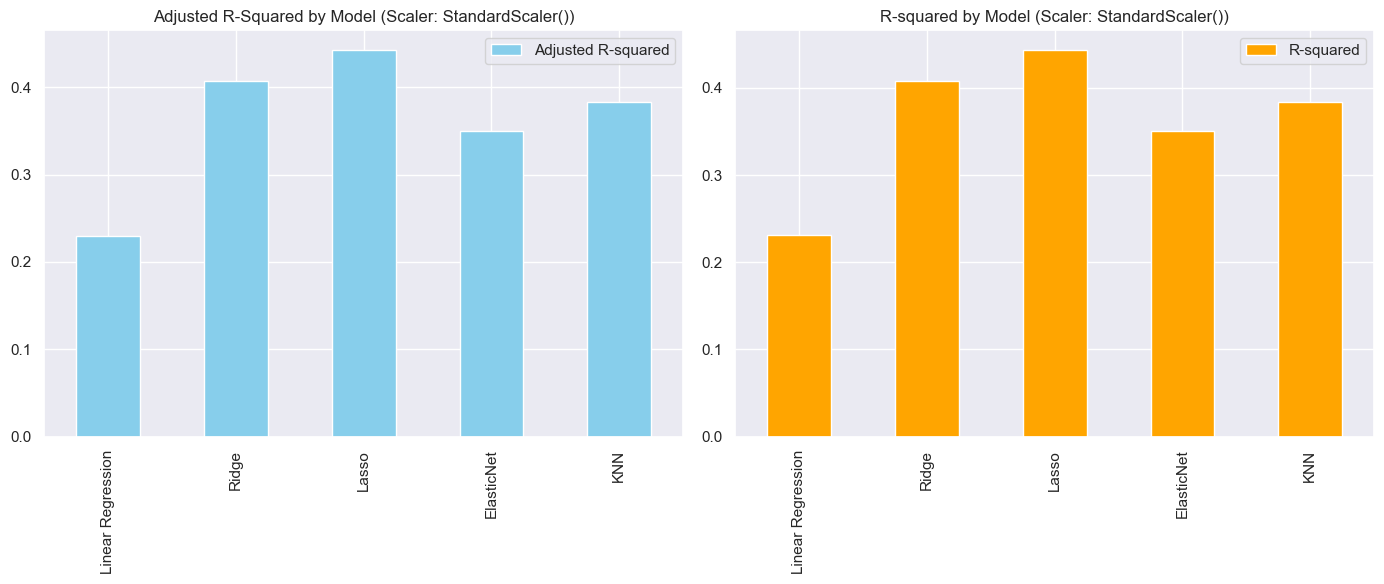

c:\Users\joshu\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+17, tolerance: 4.700e+13
  model = cd_fast.enet_coordinate_descent(


                     Mean Squared Error R-squared Adjusted R-squared
Linear Regression  5213539613318.008789   0.23407           0.233154
Ridge              3737851985604.021973  0.450866           0.450209
Lasso              3884655132800.262695  0.429299           0.428617
ElasticNet         3801906099026.443848  0.441456           0.440788
KNN                3563005556805.637207  0.476553           0.475927


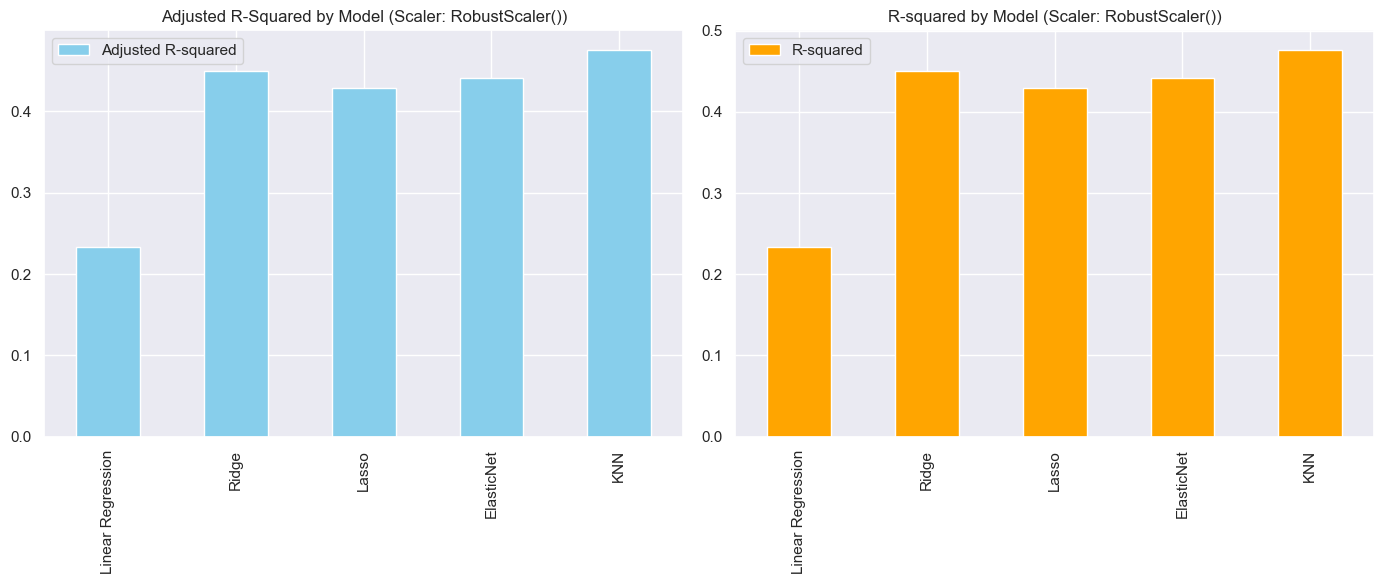

In [232]:
evaluate_regression_models(df, 'net_income', StandardScaler())
evaluate_regression_models(df, 'net_income', RobustScaler())

# Joining More Data

## Provider Info

In [233]:
# Retrieve the correct base path depending on the OS
base_path = get_file_path()

# Years for which we have data, note the exclusion of 2018
years = [2015, 2016, 2017, 2019, 2020, 2021]

# Dictionary to hold the dataframes
providerInfo_dfs = {}

# Loop through each year, load the CSV, and add the 'year' column
for year in years:
    file_path = os.path.join(base_path, f'ProviderInfo_{year}.csv')
    # Assuming all files from 2016 onwards need a specific encoding
    if year > 2015:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    else:
        df = pd.read_csv(file_path)
    
    df['year'] = year
    providerInfo_dfs[year] = df

# If you need individual dataframes, you can create them like this:
providerInfo_df2015 = providerInfo_dfs[2015]
providerInfo_df2016 = providerInfo_dfs[2016]
providerInfo_df2017 = providerInfo_dfs[2017]
providerInfo_df2019 = providerInfo_dfs[2019]
providerInfo_df2020 = providerInfo_dfs[2020]
providerInfo_df2021 = providerInfo_dfs[2021]

providerInfo_df2015.columns = providerInfo_df2015.columns.str.lower()
providerInfo_df2016.columns = providerInfo_df2016.columns.str.lower()
providerInfo_df2017.columns = providerInfo_df2017.columns.str.lower()
providerInfo_df2019.columns = providerInfo_df2019.columns.str.lower()
providerInfo_df2020.columns = providerInfo_df2020.columns.str.lower()
providerInfo_df2021.columns = providerInfo_df2021.columns.str.lower()

providerInfo_df2016.drop(columns='oldsurvey', inplace = True)
providerInfo_df2017.drop(columns='oldsurvey', inplace = True)

providerInfo_df2019.rename(columns = {'sffstatus' : 'sff'}, inplace = True)

drop2019 = ['abuse_icon', 'oldsurvey', 'ls_quality_rating', 'ls_quality_rating_fn', 'ss_quality_rating', 'ss_quality_rating_fn']

rename_exp_to_cm = {'exp_aide' : 'cm_aide', 
             'exp_lpn' : 'cm_lpn', 
             'exp_rn' : 'cm_rn' ,
             'exp_total' : 'cm_total'}

providerInfo_df2015.rename(columns = rename_exp_to_cm, inplace = True)
providerInfo_df2016.rename(columns = rename_exp_to_cm, inplace = True)
providerInfo_df2017.rename(columns = rename_exp_to_cm, inplace = True)

providerInfo_df2019.drop(columns=drop2019, inplace = True)

rename2020 = {"federal provider number":"provnum",
"provider name":"provname",
"provider address":"address",
"provider city":"city",
"provider state":"state",
"provider zip code":"zip",
"provider phone number":"phone",
"provider ssa county code":"county_ssa",
"provider county name":"county_name",
"ownership type":"ownership",
"number of certified beds":"bedcert",
"legal business name":"lbn",
"date first approved to provide medicare and medicaid services":"participation_date",
"continuing care retirement community":"ccrc_facil",
"special focus status":"sff",
"provider changed ownership in last 12 months":"chow_last_12mos",
"with a resident and family council":"resfamcouncil",
"automatic sprinkler systems in all required areas":"sprinkler_status",
"overall rating":"overall_rating",
"overall rating footnote":"overall_rating_fn",
"qm rating":"quality_rating",
"qm rating footnote":"quality_rating_fn",
"staffing rating":"staffing_rating",
"staffing rating footnote":"staffing_rating_fn",
"rn staffing rating":"rn_staffing_rating",
"rn staffing rating footnote":"rn_staffing_rating_fn",
"reported nurse aide staffing hours per resident per day":"aidhrd",
"reported lpn staffing hours per resident per day":"vochrd",
"reported rn staffing hours per resident per day":"rnhrd",
"reported licensed staffing hours per resident per day":"totlichrd",
"reported total nurse staffing hours per resident per day":"tothrd",
"reported physical therapist staffing hours per resident per day":"pthrd",
"case-mix nurse aide staffing hours per resident per day":"cm_aide",
"case-mix lpn staffing hours per resident per day":"cm_lpn",
"case-mix rn staffing hours per resident per day":"cm_rn",
"case-mix total nurse staffing hours per resident per day":"cm_total",
"adjusted nurse aide staffing hours per resident per day":"adj_aide",
"adjusted lpn staffing hours per resident per day":"adj_lpn",
"adjusted rn staffing hours per resident per day":"adj_rn",
"adjusted total nurse staffing hours per resident per day":"adj_total",
"rating cycle 1 standard survey health date":"cycle_1_survey_date",
"rating cycle 1 total number of health deficiencies":"cycle_1_defs",
"rating cycle 1 number of standard health deficiencies":"cycle_1_nfromdefs",
"rating cycle 1 number of complaint health deficiencies":"cycle_1_nfromcomp",
"rating cycle 1 health deficiency score":"cycle_1_defs_score",
"rating cycle 1 number of health revisits":"cycle_1_numrevis",
"rating cycle 1 health revisit score":"cycle_1_revisit_score",
"rating cycle 1 total health score":"cycle_1_total_score",
"rating cycle 2 standard health survey date":"cycle_2_survey_date",
"rating cycle 2 total number of health deficiencies":"cycle_2_defs",
"rating cycle 2 number of standard health deficiencies":"cycle_2_nfromdefs",
"rating cycle 2 number of complaint health deficiencies":"cycle_2_nfromcomp",
"rating cycle 2 health deficiency score":"cycle_2_defs_score",
"rating cycle 2 number of health revisits":"cycle_2_numrevis",
"rating cycle 2 health revisit score":"cycle_2_revisit_score",
"rating cycle 2 total health score":"cycle_2_total_score",
"rating cycle 3 standard health survey date":"cycle_3_survey_date",
"rating cycle 3 total number of health deficiencies":"cycle_3_defs",
"rating cycle 3 number of standard health deficiencies":"cycle_3_nfromdefs",
"rating cycle 3 number of complaint health deficiencies":"cycle_3_nfromcomp",
"rating cycle 3 health deficiency score":"cycle_3_defs_score",
"rating cycle 3 number of health revisits":"cycle_3_numrevis",
"rating cycle 3 health revisit score":"cycle_3_revisit_score",
"rating cycle 3 total health score":"cycle_3_total_score",
"total weighted health survey score":"weighted_all_cycles_score",
"number of facility reported incidents":"incident_cnt",
"number of substantiated complaints":"cmplnt_cnt",
"number of fines":"fine_cnt",
"total amount of fines in dollars":"fine_tot",
"number of payment denials":"payden_cnt",
"total number of penalties":"tot_penlty_cnt",}

drop2020 = ["average number of residents per day",
"average number of residents per day footnote",
"provider type",
"provider resides in hospital",
"abuse icon",
"most recent health inspection more than 2 years ago",
"health inspection rating",
"health inspection rating footnote",
"long-stay qm rating",
"long-stay qm rating footnote",
"short-stay qm rating",
"short-stay qm rating footnote",
"reported staffing footnote",
"physical therapist staffing footnote",
"location",
"processing date",]
providerInfo_df2020.drop(columns=drop2020, inplace = True)
providerInfo_df2020.rename(columns = rename2020, inplace = True)

providerInfo_df2021.drop(columns=drop2020, inplace = True)
providerInfo_df2021.drop(columns='number of citations from infection control inspections', inplace = True)
providerInfo_df2021.rename(columns = rename2020, inplace = True)

dropRemainingProv = ['restot','certification','inhosp','survey_rating','survey_rating_fn','staffing_flag','pt_staffing_flag', 'filedate', 'cycle_1_survey_date', 'cycle_2_survey_date', 'cycle_3_survey_date']
providerInfo_df2015.drop(columns=dropRemainingProv, inplace = True)
providerInfo_df2016.drop(columns=dropRemainingProv, inplace = True)
providerInfo_df2017.drop(columns=dropRemainingProv, inplace = True)
providerInfo_df2019.drop(columns=dropRemainingProv, inplace = True)

provMergeList = [providerInfo_df2015, providerInfo_df2016, providerInfo_df2017, providerInfo_df2019, providerInfo_df2020, providerInfo_df2021]

for each_df in provMergeList:
    each_df['provnum'] = each_df['provnum'].str.lstrip('0')


In [234]:
## uncomment to view which records are not converting to int
# for value in providerInfo_df2017['provnum'].unique():
#     try:
#         int(value)
#     except ValueError:
#         print(f"Cannot convert '{value}' to int.")

In [235]:
for each_df in provMergeList:
    # Convert 'provnum' to numeric, setting errors='coerce' to convert errors to NaN
    each_df['provnum'] = pd.to_numeric(each_df['provnum'], errors='coerce')

    # Drop rows where 'provnum' is NaN (these were the rows with conversion errors)
    each_df.dropna(subset=['provnum'], inplace=True)

    each_df['provnum'] = each_df['provnum'].astype(int)

c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)
c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)
c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)
c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)
c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)
c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, cop

In [236]:
def merge_net_income_with_provider_info(df_identifiers, provider_info_df, year):
    # Filter the dfWithIdentifiers for the given year
    cost_report = df_identifiers[df_identifiers['year'] == str(year)]
    
    # Select 'net_income' and 'provider_ccn', sort by 'provider_ccn', and rename 'provider_ccn' to 'provnum'
    net_income = cost_report[['net_income', 'provider_ccn', 'gross_revenue']].sort_values(by='provider_ccn')
    net_income.rename(columns={'provider_ccn': 'provnum'}, inplace=True)
    
    # Merge with the providerInfo_df for the given year on 'provnum'
    merged_data = pd.merge(provider_info_df, net_income, on='provnum', how='left')
    
    # Drop rows where 'net_income' is NaN and return the result
    result = merged_data.dropna(subset=['net_income'])
    
    return result

providerInfo2015_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2015, 2015)
providerInfo2016_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2016, 2016)
providerInfo2017_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2017, 2017)
providerInfo2019_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2019, 2019)
providerInfo2020_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2020, 2020)
providerInfo2021_netIncome = merge_net_income_with_provider_info(dfWithIdentifiers, providerInfo_df2021, 2021)

In [237]:
providerInfo_netIncome_mergeList = [providerInfo2015_netIncome, providerInfo2016_netIncome, providerInfo2017_netIncome, providerInfo2019_netIncome, providerInfo2020_netIncome, providerInfo2021_netIncome]

provider_df = pd.concat(providerInfo_netIncome_mergeList, ignore_index=True)

# Calculate the threshold as total rows minus 40,000
threshold = len(provider_df) - 40000

# Drop columns that have more than 40,000 null values
provider_df.dropna(thresh=threshold, inplace = True, axis = 1)
provider_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84365 entries, 0 to 84364
Data columns (total 66 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   provnum                    84365 non-null  int32  
 1   provname                   84365 non-null  object 
 2   address                    84365 non-null  object 
 3   city                       84365 non-null  object 
 4   state                      84365 non-null  object 
 5   zip                        84365 non-null  int64  
 6   phone                      84365 non-null  int64  
 7   county_ssa                 84365 non-null  int64  
 8   county_name                84365 non-null  object 
 9   ownership                  84365 non-null  object 
 10  bedcert                    84365 non-null  int64  
 11  lbn                        84365 non-null  object 
 12  participation_date         84365 non-null  object 
 13  ccrc_facil                 84365 non-null  obj

In [238]:
# Assuming provider_df is your DataFrame and 'cycle_1_nfromdefs' is the column of interest
# First, let's define a function to check if a value can be casted to int
def can_cast_to_int(value):
    try:
        float(value)
        return True
    except ValueError:
        return False


convert_to_int = [ 'cycle_1_defs',
 'cycle_1_nfromdefs',
 'cycle_1_nfromcomp',
 'cycle_1_defs_score',
 'cycle_1_numrevis',
 'cycle_1_revisit_score',
 'cycle_1_total_score',
 'cycle_2_defs',
 'cycle_2_nfromdefs',
 'cycle_2_nfromcomp',
 'cycle_2_defs_score',
 'cycle_2_numrevis',
 'cycle_2_revisit_score',
 'cycle_2_total_score',
 'cycle_3_defs',
 'cycle_3_nfromdefs',
 'cycle_3_nfromcomp',
 'cycle_3_defs_score',
 'cycle_3_numrevis',
 'cycle_3_revisit_score',
 'cycle_3_total_score',
 'weighted_all_cycles_score']

for each_col in convert_to_int:
    # Now, apply this function to each element in the column and create a mask
    mask = provider_df[each_col].apply(can_cast_to_int)
    # Filter the DataFrame to keep only the rows where the mask is True
    provider_df = provider_df[mask]
    provider_df[each_col] = provider_df[each_col].astype(float)
    print(f'cleaned {each_col} and length: {len(provider_df)}')

provider_df.dropna(inplace=True)

cleaned cycle_1_defs and length: 83677
cleaned cycle_1_nfromdefs and length: 83677
cleaned cycle_1_nfromcomp and length: 83677
cleaned cycle_1_defs_score and length: 83677
cleaned cycle_1_numrevis and length: 83677
cleaned cycle_1_revisit_score and length: 83677
cleaned cycle_1_total_score and length: 83677
cleaned cycle_2_defs and length: 83677
cleaned cycle_2_nfromdefs and length: 83677
cleaned cycle_2_nfromcomp and length: 83677
cleaned cycle_2_defs_score and length: 83677
cleaned cycle_2_numrevis and length: 83677
cleaned cycle_2_revisit_score and length: 83677
cleaned cycle_2_total_score and length: 83677
cleaned cycle_3_defs and length: 82952
cleaned cycle_3_nfromdefs and length: 82952
cleaned cycle_3_nfromcomp and length: 82952
cleaned cycle_3_defs_score and length: 82952
cleaned cycle_3_numrevis and length: 82952
cleaned cycle_3_revisit_score and length: 82952
cleaned cycle_3_total_score and length: 82952
cleaned weighted_all_cycles_score and length: 82952


In [239]:
dropProvIrrelevant = ['provnum', 'provname', 'address', 'city', 'zip', 'phone', 'county_ssa', 'county_name', 'lbn', 'participation_date']
provider_df.drop(columns=dropProvIrrelevant, inplace = True)

In [240]:
provider_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80203 entries, 0 to 84316
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   state                      80203 non-null  object 
 1   ownership                  80203 non-null  object 
 2   bedcert                    80203 non-null  int64  
 3   ccrc_facil                 80203 non-null  object 
 4   chow_last_12mos            80203 non-null  object 
 5   resfamcouncil              80203 non-null  object 
 6   sprinkler_status           80203 non-null  object 
 7   overall_rating             80203 non-null  float64
 8   quality_rating             80203 non-null  float64
 9   staffing_rating            80203 non-null  float64
 10  rn_staffing_rating         80203 non-null  float64
 11  aidhrd                     80203 non-null  float64
 12  vochrd                     80203 non-null  float64
 13  rnhrd                      80203 non-null  flo

In [241]:
ownership_mapping = {
    'For profit - Corporation': 'For Profit',
    'Non profit - Corporation': 'Non Profit',
    'For profit - Partnership': 'For Profit',
    'For profit - Limited Liability company': 'For Profit',
    'For profit - Individual': 'For Profit',
    'Non profit - Church related': 'Non Profit',
    'Government - County': 'Government',
    'Non profit - Other': 'Non Profit',
    'Government - Hospital district': 'Government',
    'Government - City/county': 'Government',
    'Government - City': 'Government',
    'Government - State': 'Government',
    'Government - Federal': 'Government'
}

# Apply the mapping to the 'ownership' column
provider_df['ownership'] = provider_df['ownership'].map(ownership_mapping)

# Check the transformed values
provider_df['ownership'].value_counts()


For Profit    59658
Non Profit    16704
Government     3841
Name: ownership, dtype: int64

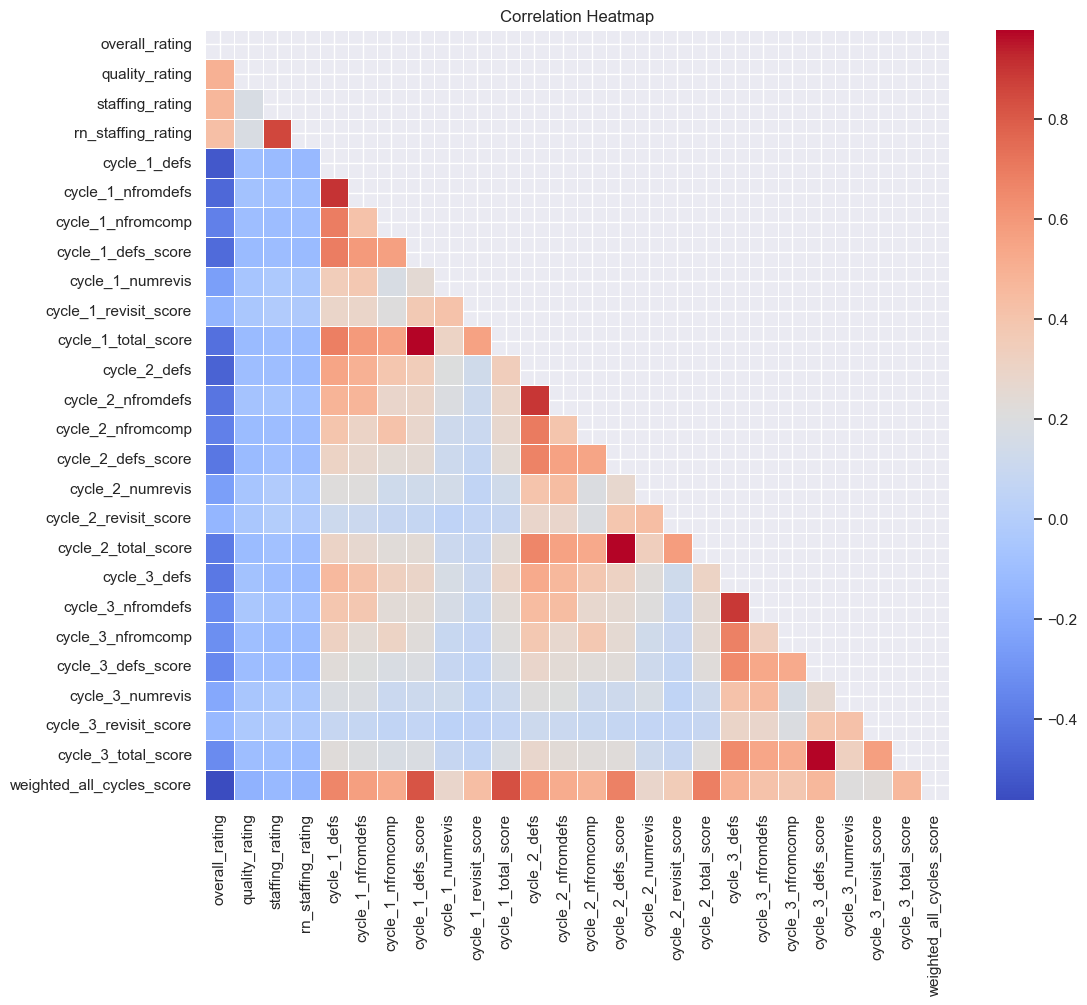

In [242]:
filtered_cols = [col for col in provider_df.columns if ("score" in col or "cycle" in col or "rating" in col)]

# Calculate correlation matrix for filtered columns
corr_matrix_prov = provider_df[filtered_cols].corr()


mask = np.triu(np.ones_like(corr_matrix_prov, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_prov, annot=False, fmt=".2f", cmap="coolwarm", 
            mask=mask, cbar=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [243]:
dropProvCorr = ['overall_rating', 'cycle_1_defs',
 'cycle_1_nfromdefs',
 'cycle_1_nfromcomp',
 'cycle_1_defs_score',
 'cycle_1_numrevis',
 'cycle_1_revisit_score',
 'cycle_2_defs',
 'cycle_2_nfromdefs',
 'cycle_2_nfromcomp',
 'cycle_2_defs_score',
 'cycle_2_numrevis',
 'cycle_2_revisit_score',
 'cycle_3_defs',
 'cycle_3_nfromdefs',
 'cycle_3_nfromcomp',
 'cycle_3_defs_score',
 'cycle_3_numrevis',
 'cycle_3_revisit_score',
 'weighted_all_cycles_score', 'rn_staffing_rating']
provider_df.drop(columns=dropProvCorr, inplace = True)

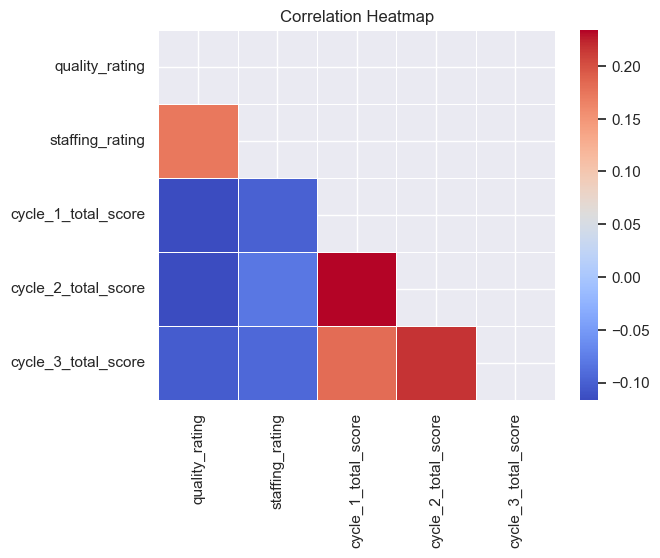

In [244]:

filtered_cols = [col for col in provider_df.columns if ("score" in col or "cycle" in col or "rating" in col)]

# Calculate correlation matrix for filtered columns
corr_matrix_prov = provider_df[filtered_cols].corr()


mask = np.triu(np.ones_like(corr_matrix_prov, dtype=bool))

# plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_prov, annot=False, fmt=".2f", cmap="coolwarm", 
            mask=mask, cbar=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [245]:
provCatFeatures = ['state', 'ownership', 'ccrc_facil', 'chow_last_12mos', 'resfamcouncil', 'sprinkler_status']
# for each in provCatFeatures:
    #provider_df = pd.concat([provider_df, pd.get_dummies(provider_df[each], prefix=each)], axis = 1)
    
provider_df.drop(columns=provCatFeatures, inplace=True, axis=1)

In [246]:
# provider_df['net_profit_margin'] = provider_df['net_income'] / provider_df['gross_revenue']

In [247]:
# rovider_df.to_csv(r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\Provider.csv')

                     Mean Squared Error R-squared Adjusted R-squared
Linear Regression  3608778150299.779297   0.03818           0.037807
Ridge              3617500972581.231445  0.035855           0.035481
Lasso              3618755121167.668945  0.035521           0.035146
ElasticNet         3624820124681.135742  0.033904           0.033529
KNN                5158488766070.234375 -0.374853          -0.375386


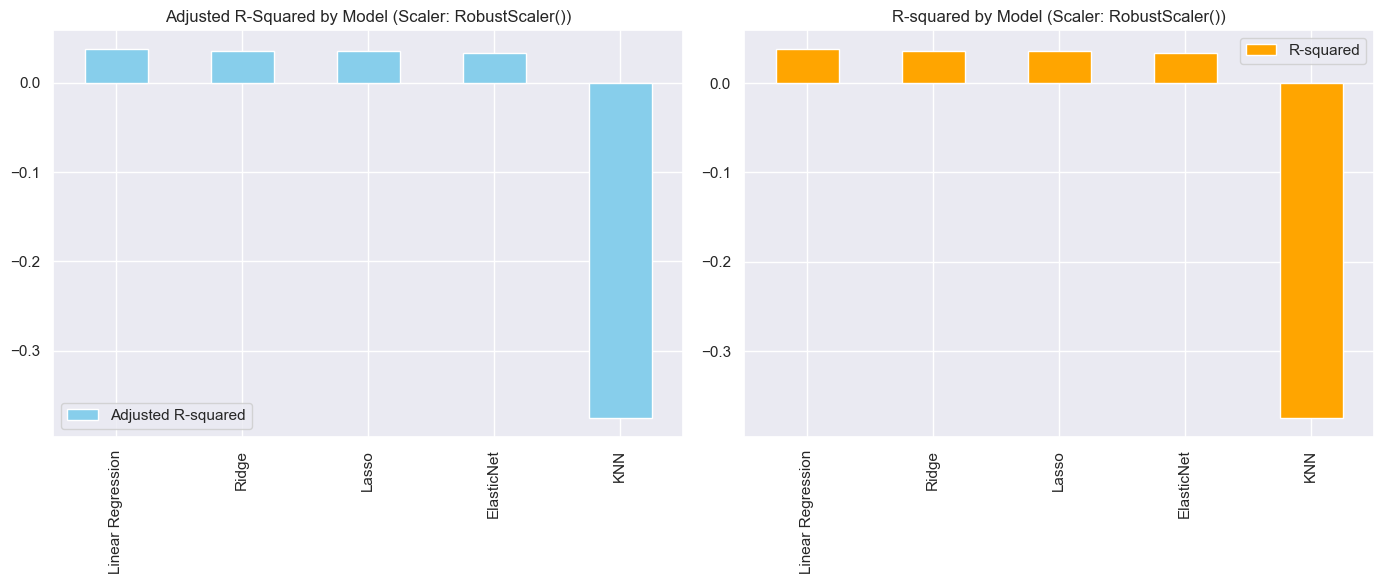

(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num', RobustScaler(),
                                                   Index(['bedcert', 'quality_rating', 'staffing_rating', 'aidhrd', 'vochrd',
        'rnhrd', 'totlichrd', 'tothrd', 'pthrd', 'cm_aide', 'cm_lpn', 'cm_rn',
        'cm_total', 'adj_aide', 'adj_lpn', 'adj_rn', 'adj_total',
        'cycle_1_total_score', 'cycle_2_total_score', 'cycle_3_total_score',
        'incident_cnt', 'cmplnt_cnt', 'fine_cnt', 'fine_tot', 'payden_cnt',
        'tot_penlty_cnt', 'year', 'gross_revenue'],
       dtype='object'))])),
                 ('regressor', LinearRegression())]),
                      Mean Squared Error R-squared  \
 Linear Regression  3608778150299.779297   0.03818   
 Ridge              3617500972581.231445  0.035855   
 Lasso              3618755121167.668945  0.035521   
 ElasticNet         3624820124681.135742  0.033904   
 KNN                5158488766070.234375 -0.374853   
 
        

In [248]:
evaluate_regression_models(provider_df, 'net_income', RobustScaler())
extract_best_regression_models(provider_df, 'net_income', RobustScaler())

                     Mean Squared Error R-squared  \
Linear Regression  3608778150299.779297   0.03818   
Ridge              3617500972581.231445  0.035855   
Lasso              3618755121167.668945  0.035521   
ElasticNet         3624820124681.135742  0.033904   
KNN                5158488766070.234375 -0.374853   

                                                            Pipeline  
Linear Regression  (ColumnTransformer(transformers=[('num', Robus...  
Ridge              (ColumnTransformer(transformers=[('num', Robus...  
Lasso              (ColumnTransformer(transformers=[('num', Robus...  
ElasticNet         (ColumnTransformer(transformers=[('num', Robus...  
KNN                (ColumnTransformer(transformers=[('num', Robus...  
                Feature   Coefficient
7                tothrd  1.442352e+09
3                aidhrd -1.019507e+09
5                 rnhrd -7.209118e+08
4                vochrd -7.013491e+08
6             totlichrd  1.078678e+08
12             cm_total  9.

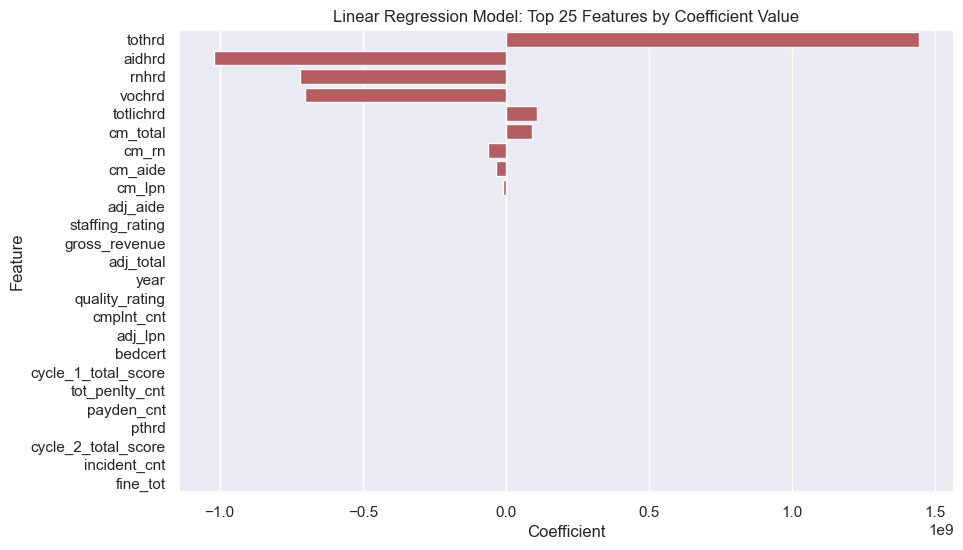

,Feature,Coefficient
7,tothrd,1.442352e+09
3,aidhrd,-1.019507e+09
5,rnhrd,-7.209118e+08
4,vochrd,-7.013491e+08
6,totlichrd,1.078678e+08
12,cm_total,9.006397e+07
11,cm_rn,-6.360561e+07
9,cm_aide,-3.460601e+07
10,cm_lpn,-1.061985e+07
13,adj_aide,-2.322130e+05


In [249]:
best_model, results = extract_best_regression_models(provider_df, 'net_income', RobustScaler())
print(results)

# Extract coefficients and feature names
coefs = best_model.named_steps['regressor'].coef_
features = best_model.named_steps['preprocessor'].transformers_[0][2]  # Assuming numerical features only

# Pair coefficients with feature names
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
# Sorting by the absolute value of the coefficients
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Dropping the auxiliary column if not needed
feature_importance_sorted.drop(columns=['abs_coefficient'], inplace=True)

print(feature_importance_sorted)

top_25_features = feature_importance_sorted.head(25)

plt.figure(figsize=(10, 6))
sns.barplot(data = top_25_features, x='Coefficient', y='Feature', color='r')
plt.title('Linear Regression Model: Top 25 Features by Coefficient Value')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

top_25_features


## COVID Data 

In [250]:
covidFilePath = r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\CovidVax_2021.csv'

covidImport_df = pd.read_csv(covidFilePath)

covidImport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15264 entries, 0 to 15263
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Federal Provider Number                  15264 non-null  object
 1   Provider State                           15264 non-null  object
 2   Percent Vaccinated Residents             15264 non-null  object
 3   Percent Vaccinated Healthcare Personnel  15264 non-null  object
 4   Date vaccination data last updated       15264 non-null  object
dtypes: object(5)
memory usage: 596.4+ KB


In [251]:
convert_to_int = ['Percent Vaccinated Residents', 'Percent Vaccinated Healthcare Personnel']

 
for each_col in convert_to_int:
    # Now, apply this function to each element in the column and create a mask
    mask = covidImport_df[each_col].apply(can_cast_to_int)
    # Filter the DataFrame to keep only the rows where the mask is True
    covidImport_df = covidImport_df[mask]
    covidImport_df[each_col] = covidImport_df[each_col].astype(float)
    print(f'cleaned {each_col} and length: {len(covidImport_df)}')

covidImport_df.dropna(inplace=True)

cleaned Percent Vaccinated Residents and length: 14841
cleaned Percent Vaccinated Healthcare Personnel and length: 14829


In [252]:
covidImport_df['Federal Provider Number'] = covidImport_df['Federal Provider Number'].str.lstrip('0')


covidImport_df['Federal Provider Number'] = pd.to_numeric(covidImport_df['Federal Provider Number'], errors='coerce')

# Drop rows where 'Federal Provider Number' is NaN (these were the rows with conversion errors)
covidImport_df.dropna(subset=['Federal Provider Number'], inplace=True)

covidImport_df['Federal Provider Number'] = covidImport_df['Federal Provider Number'].astype(int)



c:\Users\joshu\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


In [253]:
covidImport_df.drop(columns = ['Provider State', 'Date vaccination data last updated'], inplace=True)

In [254]:
covidImport_df.rename(columns={'Federal Provider Number' : 'provnum'}, inplace=True)


covid_df = merge_net_income_with_provider_info(dfWithIdentifiers, covidImport_df, 2021)

covid_df.drop(columns='gross_revenue', inplace=True)

In [255]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13640 entries, 0 to 15203
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   provnum                                  13640 non-null  int32  
 1   Percent Vaccinated Residents             13640 non-null  float64
 2   Percent Vaccinated Healthcare Personnel  13640 non-null  float64
 3   net_income                               13640 non-null  float64
dtypes: float64(3), int32(1)
memory usage: 479.5 KB


In [256]:
covid_df.to_csv(r'C:\Users\joshu\OneDrive\Desktop Files\Textbooks and Syllabi\CSUN Semester 6\BANA 620\Project\Data\covid_df.csv')

                      Mean Squared Error R-squared Adjusted R-squared
Linear Regression    6144042431109.21582 -0.003427          -0.003672
Ridge               6133697560333.525391 -0.001737          -0.001982
Lasso               6136589970091.316406  -0.00221          -0.002455
ElasticNet          6137432250859.263672 -0.002347          -0.002592
KNN                18186322255621.328125 -1.970136          -1.970862


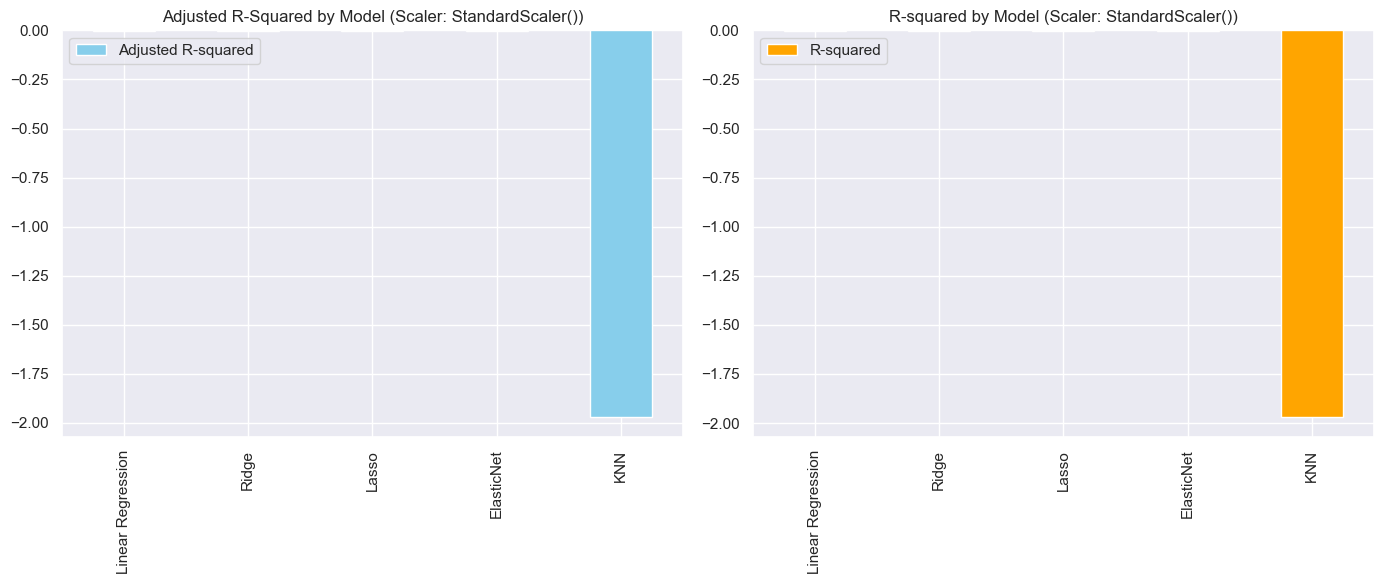

In [257]:
evaluate_regression_models(covid_df, 'net_income', StandardScaler())